In [1]:
using LinearAlgebra
using FlexiMaps
using Plots
using LaTeXStrings
using Integrals

**Noninteracting $H_{s}$**

In [2]:
fermi_dirac_distribution(ε, μ, β) = 1/(exp((ε - μ)*β) + 1) #Fermi-Dirac distribution

fermi_dirac_distribution (generic function with 1 method)

In [3]:
D = 1 #Number of system sites
L = 20 #Number of left-lead sites
R = L #Number of right-lead sites. We assume that both leads has the same size.

M = D+L+R #total number of sites of system and lead

41

In [4]:
#We need to define εk_array for each lead. In particular, we use the logarithmic-linear discretization of the paper.
W = 8.0
W_log = W #W
W_lin = W_log/2 #W* = W/2

L_log = L*0.2
L_lin = L - L_log

# e_k = 2*W_lin/L_lin #εk+1 - εk in the linear window [-W*, W*]
# εk_lin_window = [-W_lin + k*e_k for k=0:Int(L_lin-1)]
# Λ_log = W_log^(-1/L_log) #[εn-1 - εn] = [+-Λ^-(-n - 1), +-Λ^-n] in the logarithmic windows [-W, -W*] and [W*, W]

16.0

In [5]:
Lin_Window = LinRange(-W_lin, W_lin, Int(L_lin))
Log_Window = maprange(log, W_lin, W_log, length=Int(L_log/2 + 1))

εk_array = []
append!(εk_array, -reverse(Log_Window[2:length(Log_Window)]))
append!(εk_array, Lin_Window)
append!(εk_array, Log_Window[2:length(Log_Window)])

20-element Vector{Any}:
 -8.0
 -5.656854249492379
 -4.0
 -3.466666666666667
 -2.9333333333333336
 -2.4000000000000004
 -1.866666666666667
 -1.3333333333333337
 -0.7999999999999998
 -0.2666666666666666
  0.2666666666666666
  0.7999999999999998
  1.333333333333333
  1.8666666666666663
  2.4000000000000004
  2.9333333333333336
  3.466666666666667
  4.0
  5.656854249492379
  8.0

In [6]:
γk_array = [εk_array[k+1] - εk_array[k] for k=1:Int(L/2)]
append!(γk_array, reverse(γk_array))

20-element Vector{Float64}:
 2.343145750507621
 1.6568542494923788
 0.5333333333333332
 0.5333333333333332
 0.5333333333333332
 0.5333333333333334
 0.5333333333333332
 0.5333333333333339
 0.5333333333333332
 0.5333333333333332
 0.5333333333333332
 0.5333333333333332
 0.5333333333333339
 0.5333333333333332
 0.5333333333333334
 0.5333333333333332
 0.5333333333333332
 0.5333333333333332
 1.6568542494923788
 2.343145750507621

Let's compare $J_{eff}(\omega)$ (equation 17) vs $J(\omega)$ (equation 37).

In [7]:
Γ = W/8
Kp_array = [sqrt(Γ*γ/(2*pi)) for γ  = γk_array]

J(ω) = abs(ω) <= abs(W) ? Γ : 0 #Spectral density

function J_eff(Kp_array, γk_array, εk_array, ω)
    Value = 0
    for i=1:length(εk_array) #1,...,L
        Value += (abs(Kp_array[i])^2)*γk_array[i]/((ω - εk_array[i])^2 + (γk_array[i]/2)^2)
    end
    return Value
end    

J_eff (generic function with 1 method)

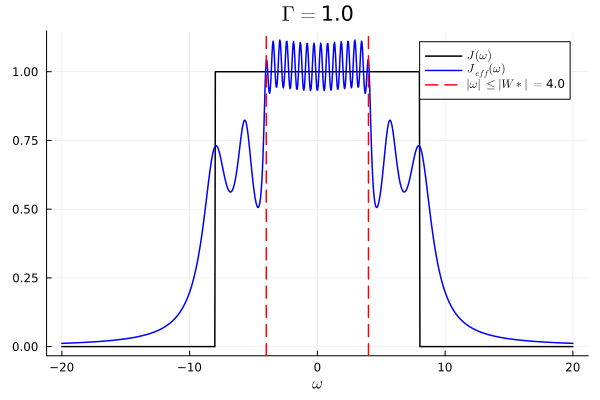

In [8]:
ω_domain = LinRange(-20,20,1000)
J_effective = [J_eff(Kp_array, γk_array, εk_array, ω) for ω=ω_domain]
J_real = [J(ω) for ω=ω_domain]

plot(ω_domain, J_real, color = "black", label =  L"J(\omega)", linewidth = 1.5)
plot!(ω_domain, J_effective, color = "blue", label = L"J_{eff}(\omega)", linewidth = 1.5)
xlabel!(L"\omega")
title!(L"\Gamma = "*string(Γ))
vline!([-W_lin, W_lin], label = L"| \omega | \leq |W*| = "*string(W_lin), color = "red", linewidth = 1.5, linestyle = :dash)

In this case we are taking the temperature and the distribution of lead mode energies {εk}, widths {γk}, and couplings {kp} to be identical for each lead. However the chemical potential is different, then {fk} is different for each lead.

In [9]:
μ_L, μ_R = W/16, -W/16
β_L, β_R = 1/(W/8), 1/(W/8)

fk_array_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk_array]
fk_array_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk_array]

20-element Vector{Float64}:
 0.9994472213630764
 0.9942731951145961
 0.9706877692486436
 0.9510453163836567
 0.919334075010081
 0.8698915256370021
 0.7968410695441768
 0.6970592839654074
 0.5744425168116589
 0.4419298941260467
 0.3172006139065875
 0.21416501695744142
 0.13784165696493575
 0.08575010225449593
 0.05215356307841772
 0.031269800995788806
 0.01858452463482168
 0.01098694263059318
 0.002114428076344818
 0.00020342697805520653

In [10]:
Γ_plus = zeros(M,M) 
Γ_minus = zeros(M,M)

for i=1:L
    Γ_plus[i,i] = γk_array[i]*fk_array_L[i]
    Γ_minus[i,i] = γk_array[i]*(1 - fk_array_L[i])
end

for i=L+D+1:M #If R = 0, then L+D=M and the for is i = M+1:M.
    #Two ideas because it is not explained in the article:
    
    Γ_plus[i,i] = γk_array[i - (L + D)]*fk_array_R[i - (L + D)] #diag(γ1fL_1, ..., γLfL_L, 0, ..., 0,γ1fR_1, ..., γRfR_R)
    Γ_minus[i,i] = γk_array[i - (L + D)]*(1 - fk_array_R[i - (L + D)])

    # Γ_plus[i,i] = reverse(γk_array)[i - (L + D)]*reverse(fk_array_R)[i - (L + D)] #diag(γ1fL_1, ..., γLfL_L, 0, ..., 0,γRfR_R, ..., γ1fR_1)
    # Γ_minus[i,i] = reverse(γk_array)[i - (L + D)]*(1 - reverse(fk_array_R)[i - (L + D)])
end

In [11]:
function Hamiltonian(ε, εk_array_L, εk_array_R, Kp_array_L,  Kp_array_R)
    M = length(εk_array_L) + 1 + length(εk_array_R)

    H_Matrix = zeros(Float64, M, M)
    
    εi = []
    append!(εi, εk_array_L) #εk_array_L
    append!(εi, ε)
    append!(εi, εk_array_R) #εk_array_R
    
    Kpi = []
    append!(Kpi, Kp_array_L) #Kp_array_L
    append!(Kpi, ε)
    append!(Kpi, Kp_array_R) #Kp_array_R
    
    for i = 1:M
        H_Matrix[i,i] = εi[i]
        H_Matrix[i, length(εk_array_L) + 1] = Kpi[i]
        H_Matrix[length(εk_array_L) + 1, i] = conj(Kpi[i])
    end
        
    return H_Matrix
end

Hamiltonian (generic function with 1 method)

In [12]:
function Diagonalize_L_Generator(ε, εk_array, Kp_array, Γ_plus, Γ_minus)

    Λ = (Γ_minus + Γ_plus)/2
    Ω = (Γ_minus - Γ_plus)/2    
    
    M = size(Γ_minus)[1]
    L_Matrix = zeros(Complex{Float64}, 2*M, 2*M)

    H_Matrix = Hamiltonian(ε, εk_array, εk_array, Kp_array,  Kp_array)
    
    L_Matrix[1:M,1:M] = H_Matrix - 1im*Ω
    L_Matrix[1:M,M+1:2*M] = 1im*Γ_plus
    L_Matrix[M+1:2*M,1:M] = 1im*Γ_minus
    L_Matrix[M+1:2*M,M+1:2*M] = H_Matrix + 1im*Ω
    
    #Let's diagonalize L_Matrix
    
    Eigvals, V = eigen(L_Matrix)
    
    ε_matrix = zeros(Complex{Float64},2*M, 2*M)
    for i =1:2*M
        ε_matrix[i,i] = Eigvals[i]
    end
    
    #Let's check this diagonalization
    isapprox(V*ε_matrix*inv(V), L_Matrix)

    return V, ε_matrix
end

Θ(x) = x >= 0 ? 1.0 : -1.0 
    
function two_point_correlations(i,j, V, ε_matrix)
    V_inv = inv(V)
    
    correlation = 0
    for k = 1:size(V)[1]
            correlation += V[j,k]*Θ(imag(ε_matrix[k,k]))*V_inv[k,i] #Vjk*Dkl*Vinvli = Vjk*Θ(imag(ε_matrix[k,k]))*Vinvki because D is diagonal.
    end
    return correlation
end
    
function Particle_Current(ε, εk_array, Kp_array, Γ_plus, Γ_minus, fk_array_L, γk_array)

    V, ε_matrix = Diagonalize_L_Generator(ε, εk_array, Kp_array, Γ_plus, Γ_minus)
    
    current = 0
    for i=1:length(fk_array_L)
        current += γk_array[i]*fk_array_L[i] - two_point_correlations(i,i, V, ε_matrix)
    end

    return current
end

function Energy_Current(ε, εk_array, Kp_array, Γ_plus, Γ_minus, fk_array_L, γk_array)

    V, ε_matrix = Diagonalize_L_Generator(ε, εk_array, Kp_array, Γ_plus, Γ_minus)
    
    L = length(fk_array_L)
    current = 0
    for i=1:L
        current += γk_array[i]*εk_array[i]*fk_array_L[i] - two_point_correlations(i,i, V, ε_matrix)
        current += 0.5*(γk_array[i]*Kp_array[i]*two_point_correlations(L+1,i, V, ε_matrix) + γk_array[i]*conj(Kp_array[i])*two_point_correlations(i, L+1, V, ε_matrix))
    end    

    return current
end

Energy_Current (generic function with 1 method)

In [13]:
Particle_Current(0.5*W, εk_array, Kp_array, Γ_plus, Γ_minus, fk_array_L, γk_array)

6.99665693168774 + 5.366420965405522e-14im

In [14]:
onsite_energies = LinRange(-1,1, 50)*W

50-element LinRange{Float64, Int64}:
 -8.0, -7.67347, -7.34694, -7.02041, …, 7.02041, 7.34694, 7.67347, 8.0

In [15]:
JP_array = [abs(Particle_Current(ε, εk_array, Kp_array, Γ_plus, Γ_minus, fk_array_L, γk_array)) for ε = onsite_energies]
JE_array = [abs(Energy_Current(ε, εk_array, Kp_array, Γ_plus, Γ_minus, fk_array_L, γk_array)) for ε = onsite_energies]

50-element Vector{Float64}:
 37.567760374973474
 37.57770650352061
 37.58721860244013
 37.5960355202106
 37.6040211907726
 37.611296778329574
 37.61827071607896
 37.625431369586856
 37.632934133986566
 37.64025619359505
 37.646216613175724
 37.64943544218507
 37.6490917190683
  ⋮
 37.66731393570785
 37.65810232706613
 37.64833927080948
 37.63875785235252
 37.62983367660833
 37.621622003008135
 37.613794409351684
 37.60587131350818
 37.597494844588844
 37.58855580971888
 37.579150894355195
 37.569475193908424

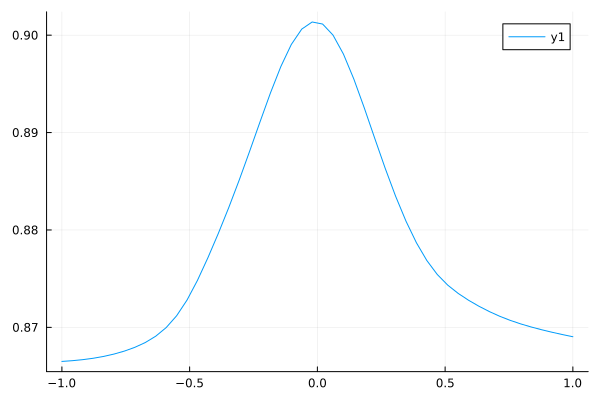

In [16]:
plot(onsite_energies/W, JP_array/W)

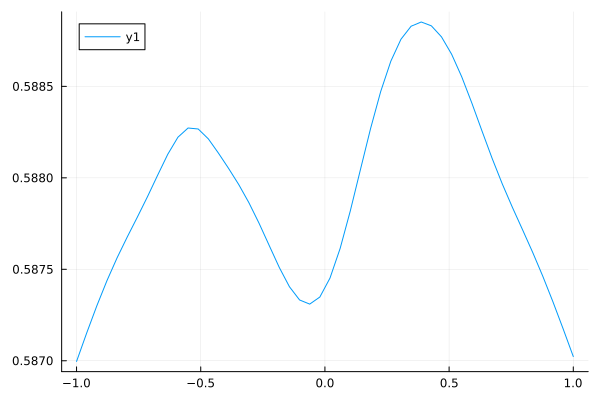

In [17]:
plot(onsite_energies/W, JE_array/(W^2))

Now I need to calculate the currents using Landauer-Buttiker formulas.

In [116]:
function Particle_Current_LB_Integrand(ω, p)
    ε = p[1]
    # Transmission_Function = J(ε)^2/abs(ω - ε +1im*J(ω))^2
    # Transmission_Function = J(ε)^2/abs(ω - ε -2*(J(ω)*1im*(pi - 0.5)))^2
    Transmission_Function = J(ε)^2/abs(ω - ε)^2
    return Transmission_Function*(fermi_dirac_distribution(ω, μ_L, β_L) - fermi_dirac_distribution(ω, μ_R, β_R))/(2*pi)
end

function Energy_Current_LB_Integrand(ω, p)
    ε = p[1]
    # Transmission_Function = J(ε)^2/abs(ω - ε +1im*J(ω))^2
    # Transmission_Function = J(ε)^2/abs(ω - ε -2*(J(ω)*1im*(pi - 0.5)))^2
    Transmission_Function = J(ε)^2/abs(ω - ε)^2
    return ω*Transmission_Function*(fermi_dirac_distribution(ω, μ_L, β_L) - fermi_dirac_distribution(ω, μ_R, β_R))/(2*pi)
end

Energy_Current_LB_Integrand (generic function with 1 method)

In [123]:
domain = (-W,W)

Particle_Current_LB = []
Energy_Current_LB = []

for ε=onsite_energies
    
    prob = IntegralProblem(Particle_Current_LB_Integrand, domain, [ε])
    sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
    append!(Particle_Current_LB, sol.u)
    
    prob = IntegralProblem(Energy_Current_LB_Integrand, domain, [ε])
    sol = solve(prob, HCubatureJL(); reltol = 1e-3, abstol = 1e-3)
    append!(Energy_Current_LB, sol.u)

end

In [124]:
Particle_Current_LB_Integrand(2, [1])

0.016960719535574074

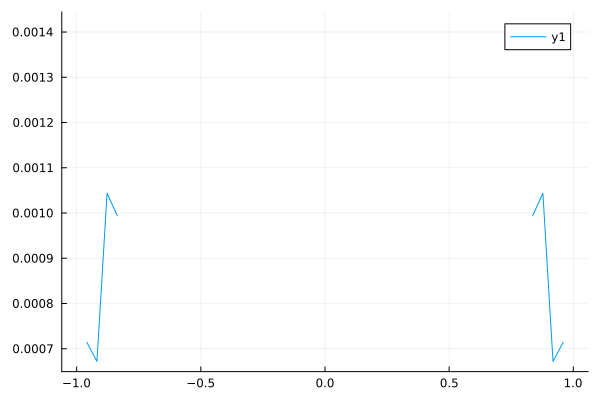

In [128]:
plot(onsite_energies/W, Particle_Current_LB/(W))

In [129]:
onsite_energies

50-element LinRange{Float64, Int64}:
 -8.0, -7.67347, -7.34694, -7.02041, …, 7.02041, 7.34694, 7.67347, 8.0